# Lab 10

We would like to use logistic regression for the purposes of formulating a trading strategy. Here, we define the logit function, and would like to perform regression with respect to this formula:

$$
Logit = \log \frac{p}{1-p} = w_0 + \sum_{i=1}^q w_ix_i = z
$$

We can invert this expression to find our probability of the classification being "positive":

$$
p = \frac{e^z}{1 + e^z} = \frac{1}{e^{-z} + 1}
$$

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Base Libraries
import pandas as pd
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

# Classifier
from sklearn.linear_model import LogisticRegression

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit
)
# Metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
    log_loss
)

### Elementary Data Analysis

In [2]:
# Get data
df = pd.read_csv('https://raw.githubusercontent.com/kannansingaravelu/datasets/main/niftyindex.csv',
                 index_col=0,parse_dates=True, 
                 dayfirst=True)
df.head(2)

,Open,High,Low,Close,Volume
2012-01-02,4640.2,4645.95,4588.05,4636.75,108461000
2012-01-03,4675.8,4773.10,4675.80,4765.30,146621008


In [3]:
# Get Info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2719 entries, 2012-01-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2719 non-null   float64
 1   High    2719 non-null   float64
 2   Low     2719 non-null   float64
 3   Close   2719 non-null   float64
 4   Volume  2719 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 127.5 KB


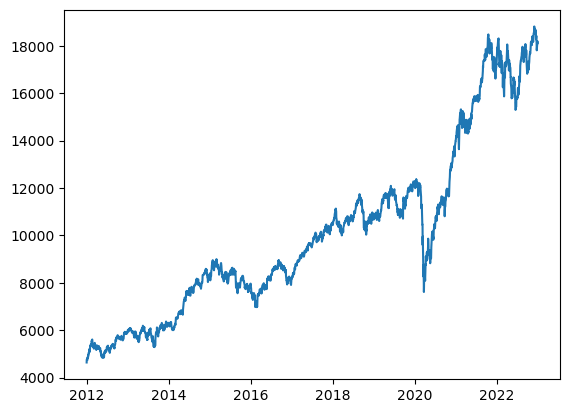

In [4]:
# Visualize data
plt.plot(df['Close'])

In [5]:
# Get basic statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2719.0,1.012490e+04,3.709607e+03,4640.20,7.637000e+03,9.376950e+03,1.170085e+04,1.887195e+04
High,2719.0,1.017529e+04,3.725527e+03,4645.95,7.681000e+03,9.431900e+03,1.175512e+04,1.888760e+04
Low,2719.0,1.005747e+04,3.685305e+03,4588.05,7.581650e+03,9.301350e+03,1.163133e+04,1.877820e+04
Close,2719.0,1.011757e+04,3.706945e+03,4636.75,7.623800e+03,9.351850e+03,1.168400e+04,1.881250e+04
Volume,2719.0,2.892221e+08,1.952768e+08,2826000.00,1.591780e+08,2.194961e+08,3.409088e+08,1.810971e+09


In [6]:
 # Check for missing values
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [7]:
# Create Features
df['HC'] = df['High'] - df['Close'] # High-Close diff
df['RET'] = np.log(df['Close'] / df['Close'].shift(1)) # Close daily return
df['MA7'] = df['Close'] / df['Close'].rolling(7).mean() # 7d Moving Average
df['VMA7'] = df['Volume'] / df['Volume'].rolling(7).mean() # 7d Volume Moving Average

df['OC_'] = df['Close'] / df['Open'] - 1 # %-difference of close to open
df['OC7'] = df['OC_'].rolling(7).mean() # 7d MA of above
df['OC24'] = df['OC_'].rolling(14).mean() # 24d MA of above

df['HC_'] = df['High'] / df['Low'] - 1 # %-difference of high to low
df['HC7'] = df['HC_'].rolling(7).mean() # 7d MA of above

df['GAP_'] = df['Open'] / df['Close'].shift(1) - 1 # %-difference of open-close gap
df['GAP7'] = df['GAP_'].rolling(7).mean() # 7d MA of above

df['STD7'] = df['RET'].rolling(7).std() # 7d rolling std
df['UB7'] = df['Close'].rolling(7).mean() + df['Close'].rolling(7).std() * 2 # 2 std upper confidence bounds

df.dropna(inplace=True)
features = df.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'OC_', 'HC_', 'GAP_'], 
                   axis=1)
features.head(2)

,HC,RET,MA7,VMA7,OC7,OC24,HC7,GAP7,STD7,UB7
2012-01-19,5.40,0.012553,1.021970,1.002220,0.002518,0.003754,0.010942,0.002402,0.008689,5049.501848
2012-01-20,15.55,0.006000,1.022538,1.079615,0.002689,0.003860,0.011600,0.002754,0.008620,5101.753784


In [8]:
# Cast values to array
X = features.values

### Label Specification

Here, the target variable will be determined as whether the underlying price will close up or down on the next trading day. The threshold we use here is 0.995, i.e if tomorrow's closing price is more than 0.995 the current day's closing price, we buy the underlying, or else we will sell it.

Set a value of 1 for the buy signal and 0 otherwise. The target is:

$$
y_t = \begin{cases} + 1 & \text{if } p_{t+1} > 0.995p_t \\
- 1 & \text{otherwise}
\end{cases}
$$

Where $p_t$ is the current closing price of the underlying and $p_{t+1}$  is the 1-day forward closing price of the underlying.

In [9]:
# Specify y
y = np.where(df['Close'].shift(-1) > 0.995 * df['Close'], 1, 0)

In [10]:
# Check Class Imbalance
pd.Series(y).value_counts()

1    2060
0     646
Name: count, dtype: int64

Interestingly, this dataset is pretty imbalanced, roughly 16:5 of 1s to 0s

### Base Model
We use Pipelines to build the models. The scaler we use will be the `StandardScaler ` as we assume the returns have non-compact supports for their distributions, so there would be no definable absolute max & min.

In [11]:
# Split the Data into Training and Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, shuffle=False)

In [12]:
# Define a baseline model
classifier = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

classifier.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(class_weight='balanced'))])

In [13]:
# Verify class labels
classifier.classes_

array([0, 1])

In [14]:
# Predict the class labels
y_pred = classifier.predict(X_test)
y_pred[-20:]

array([0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0])

In [15]:
# Predict probabilities
y_proba = classifier.predict_proba(X_test)
y_proba[-20:]

array([[0.50758194, 0.49241806],
       [0.55590046, 0.44409954],
       [0.51500312, 0.48499688],
       [0.51387063, 0.48612937],
       [0.4791692 , 0.5208308 ],
       [0.52906104, 0.47093896],
       [0.49496893, 0.50503107],
       [0.47445444, 0.52554556],
       [0.47817122, 0.52182878],
       [0.47474224, 0.52525776],
       [0.51484705, 0.48515295],
       [0.55240433, 0.44759567],
       [0.48100897, 0.51899103],
       [0.49909975, 0.50090025],
       [0.55069199, 0.44930801],
       [0.51164787, 0.48835213],
       [0.51578994, 0.48421006],
       [0.52723082, 0.47276918],
       [0.47276593, 0.52723407],
       [0.50147637, 0.49852363]])

In [16]:
# Get scores
acc_train = accuracy_score(y_train, 
                           classifier.fit(X_train, y_train).predict(X_train))
acc_test = accuracy_score(y_test, classifier.predict(X_test))
print(f'Baseline Model -- Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}')

Baseline Model -- Train Accuracy: 0.5707, Test Accuracy: 0.5535


### Prediction Quality

We use a confusion matrix to visualize our results

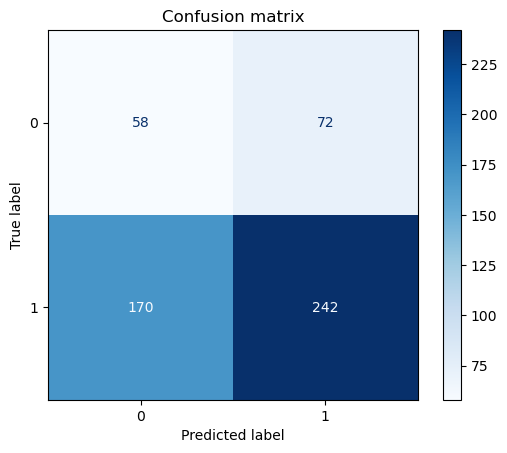

In [17]:
# Display confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    classifier,
    X_test,
    y_test,
    # display_labels=model.classes_,
    cmap=plt.cm.Blues
)
plt.title('Confusion matrix')
plt.show()

We also view the Receiver Operator Characteristic Curve (ROC). The higher the ROC curve, the better the model at distinguishing the predicted classes.

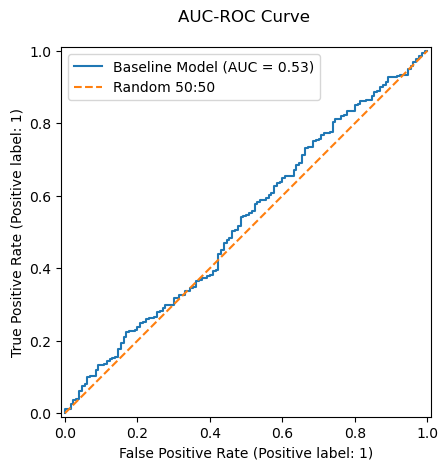

In [18]:
# Display ROC curve
disp = RocCurveDisplay.from_estimator(
    classifier,
    X_test,
    y_test,
    name='Baseline Model'
)
plt.title('AUC-ROC Curve \n')
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

The ROC curve suggests that this classifier has similar success to just flipping a coin. We observe the classification report as well, with the Macro Average and the Weighted Average.

In [19]:
# Classification Report
print(classification_report(y_test, classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.25      0.45      0.32       130
           1       0.77      0.59      0.67       412

    accuracy                           0.55       542
   macro avg       0.51      0.52      0.50       542
weighted avg       0.65      0.55      0.58       542



### Hyperparameter tuning

We need to optimize the parameters used by the estimator itself in order to get good results. TO do so, we will search the hyper-parameter space to get the best cross-validation score.

#### Time Series Cross-Validation
Time series data have a correlation between samples and dependence across time. This being the case, typical methods like K-clusters will return poor scores.

We use the forward chaining method this time to preserve the order, where each training set is an expanding window, with a window of fixed size after being the test set.

We will also use TimeSeriesSplit, a variation of KFold suitable for Time Series data.

In [20]:
# Get Params list
classifier.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('classifier', LogisticRegression(class_weight='balanced'))],
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': LogisticRegression(class_weight='balanced'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__C': 1.0,
 'classifier__class_weight': 'balanced',
 'classifier__dual': False,
 'classifier__fit_intercept': True,
 'classifier__intercept_scaling': 1,
 'classifier__l1_ratio': None,
 'classifier__max_iter': 100,
 'classifier__multi_class': 'auto',
 'classifier__n_jobs': None,
 'classifier__penalty': 'l2',
 'classifier__random_state': None,
 'classifier__solver': 'lbfgs',
 'classifier__tol': 0.0001,
 'classifier__verbose': 0,
 'classifier__warm_start': False}

In [21]:
# Use Optuna for Tuning
import optuna

In [22]:
# Define Objective Function
def optimize(trial, x, y):

    # specify parameter range
    tolerance = trial.suggest_float('tol', 0.001, 0.01, log=True)
    regularization = trial.suggest_float('C', 0.001, 1, log=True)

    model = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(
            C=regularization,
            tol=tolerance,
            class_weight='balanced'
        ))
    ]) 

    tscv = TimeSeriesSplit(n_splits=2, gap=1)
    ll = []

    for idx in tscv.split(x):
        train_idx, test_idx = idx[0], idx[1]
        xtrain = x[train_idx]
        ytrain = y[train_idx]

        xtest = x[test_idx]
        ytest = y[test_idx]

        model.fit(xtrain, ytrain)
        preds = model.predict(xtest)

        ll.append(log_loss(ytest, preds))

    return -1.0 * np.mean(ll)

In [23]:
# Create a study
study = optuna.create_study(
    study_name='hp_lr',
    direction='minimize'
)

[I 2024-05-21 00:50:00,875] A new study created in memory with name: hp_lr


In [24]:
# Specify optimization function
optimization_function = partial(optimize, x=X, y=y)
study.optimize(optimization_function, n_trials=20)

[I 2024-05-21 00:50:00,894] Trial 0 finished with value: -13.626259208080874 and parameters: {'tol': 0.006566007158339331, 'C': 0.007344647214708134}. Best is trial 0 with value: -13.626259208080874.


[I 2024-05-21 00:50:00,903] Trial 1 finished with value: -13.846037582404758 and parameters: {'tol': 0.004407980287604043, 'C': 0.003371557483841034}. Best is trial 1 with value: -13.846037582404758.
[I 2024-05-21 00:50:00,912] Trial 2 finished with value: -12.926964380686695 and parameters: {'tol': 0.0037832753630264904, 'C': 0.35413812850517323}. Best is trial 1 with value: -13.846037582404758.
[I 2024-05-21 00:50:00,921] Trial 3 finished with value: -13.266621868278154 and parameters: {'tol': 0.0010246567339628867, 'C': 0.004855966918620521}. Best is trial 1 with value: -13.846037582404758.
[I 2024-05-21 00:50:00,930] Trial 4 finished with value: -13.046843493954267 and parameters: {'tol': 0.002493764480408558, 'C': 0.5551532780218356}. Best is trial 1 with value: -13.846037582404758.
[I 2024-05-21 00:50:00,938] Trial 5 finished with value: -13.885997286827283 and parameters: {'tol': 0.0018740974302073976, 'C': 0.0015588811921781495}. Best is trial 5 with value: -13.885997286827283.

In [25]:
# Get the Best Params
print(f'Best Params: {study.best_params}, Best Value: {study.best_value}')

Best Params: {'tol': 0.004426327111363039, 'C': 0.0010134694079767536}, Best Value: -14.265614478841268


### Visualize Optimization

In [26]:
# plot Optimization History
optuna.visualization.plot_optimization_history(study)

In [27]:
# Plot Param Importances
optuna.visualization.plot_param_importances(study)

In [28]:
# plot accuracies for each HP trail
optuna.visualization.plot_slice(study)

In [29]:
# plot the surface
optuna.visualization.plot_contour(study, params=['tol', 'C'])

In [30]:
# plot parallel coordinates
optuna.visualization.plot_parallel_coordinate(study)

### Tuned Model

Now, we will use these best parameters and see how much better the regressor fares:

In [31]:
# Scale and fit the model
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("estimator", LogisticRegression(
    tol=study.best_params['tol'],
    C=study.best_params['C'],
    class_weight='balanced',
    ))
])

clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 LogisticRegression(C=0.0010134694079767536,
                                    class_weight='balanced',
                                    tol=0.004426327111363039))])

In [32]:
# Predict Class Labels
y_pred = clf.predict(X_test)

# Predict Probabilities for upside
# y_proba = model.best_estimator_.predict_proba(X_test)[:,1]

# Measure Accuracy
acc_train = accuracy_score(y_train, clf.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

# Print Accuracy
print(f'\n Training Accuracy \t: {acc_train :0.4} \n Test Accuracy \t\t: {acc_test :0.4}')


 Training Accuracy 	: 0.5809 
 Test Accuracy 		: 0.5941


**Confusion Matrix**

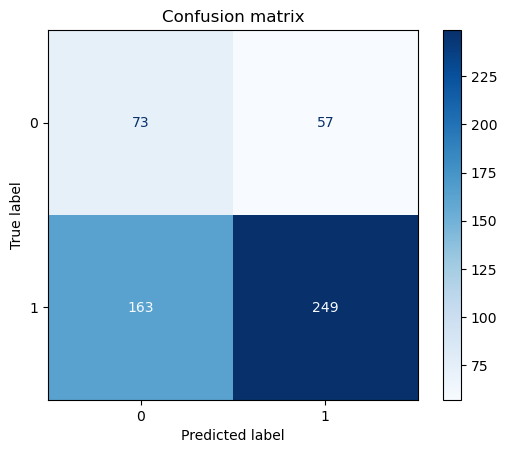

In [33]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    # display_labels=model.classes_,
    cmap=plt.cm.Blues
)
plt.title('Confusion matrix')
plt.show()

We definitely see an improvement across all possibilities

**ROC Curve**

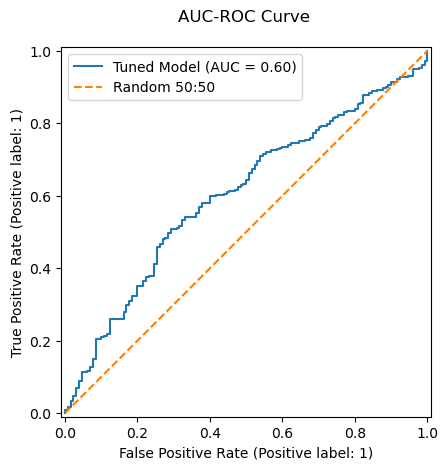

In [34]:
# Display ROCCurve
disp = RocCurveDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    name='Tuned Model')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

ROC is marginally higher.

**Classification Report**

In [35]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.31      0.56      0.40       130
           1       0.81      0.60      0.69       412

    accuracy                           0.59       542
   macro avg       0.56      0.58      0.55       542
weighted avg       0.69      0.59      0.62       542



### Trading Strategy
We use the predicted states to create a trading signal:

In [36]:
df2 =pd.read_csv('https://raw.githubusercontent.com/kannansingaravelu/datasets/main/niftyindex.csv',
                 index_col=0,parse_dates=True, 
                 dayfirst=True)
df2 = df2.iloc[13:,:]

# Get Prediction
df2['Signal'] = clf.predict(X)

# Define Entry Logic
df2['Entry'] = np.where(df2['Signal']==1, df2['Close'], 0)

# Defining Exit Logic
df2['Exit'] = np.where((df2['Entry'] != 0) & (df2['Open'].shift(-1) <= df2['Close']),
                       df['Open'].shift(-1), 0)
df2['Exit'] = np.where((df2['Entry'] != 0) & (df2['Open'].shift(-1) > df2['Close']),
                       df2['Close'].shift(-1), df2['Exit'])

# Calculate MTM
df2['P&L'] = df2['Exit'] - df2['Entry']

# Generate Equity Curve
df2['Equity'] = df2['P&L'].cumsum() + df2['Close'][0]

# Calculate Benchmark Return
df2['Returns'] = np.log(df2['Close']).diff().fillna(0)

# Calculate Strategy Return
df2['Strategy'] = (df2['Equity']/df2['Equity'].shift(1) - 1).fillna(0)
df2 = df2.iloc[:-1]

In [37]:
# Generate HTML Strategy Report
# Refer HTML file for report
import quantstats as qs
qs.reports.html(df2['Strategy'], df2['Returns'])